In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger
from datetime import datetime
import h5py
import gzip

# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)

run_num = '12036'
os.chdir('F:/LANL/')
datadir = 'sample_data/'
runs_folder = 'runs12034-12363/'
uniquefolder = 'debug_sample/'+runs_folder
# uniquefolder = 'La_sample/'
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num
SFNormFile = 'SF_Norm_files/'+runs_folder+run_num
# AsymSavename = '****testing testing testing'

# print(os.getcwd())

# os.chdir('F:/LANL/')
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num

statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
processedONOFFfolder = '/processed_data/'+uniquefolder+'ONOFF_D/'
processedasymfolder = '/processed_data/'+uniquefolder+'asym_D/'
ONOFFSavename = os.getcwd()+processedONOFFfolder+run_num+'_ONOFF_D'
AsymSavename = os.getcwd()+processedasymfolder+run_num+'_asym_D'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'_D.txt', delay = False)

# cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed ##
# chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all
chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream
# chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream

print('processing data: ' + uniquefolder + '/run' + run_num)

# print(os.getcwd()+processedpulsefolder)
# if not os.path.exists(os.getcwd()+processedpmfolder) or not os.path.exists(os.getcwd()+processedasymfolder):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedpmfolder)
#     os.makedirs(os.getcwd()+processedasymfolder)
#     print("Directory created successfully")
# else:
#     pass

# print(os.getcwd() + folder)

# get_ipython().run_line_magic('matplotlib', 'qt')

start = time.time()
fullstart = time.time()

read_data = []
fileLength = []

def open_file():
    for el in chan_enab:
        # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    logger.error(run_num + emessage)
    raise Exception(emessage)

end = time.time()

# print('file open time: ' + str(end-start))            
print('saving processed data to ' + AsymSavename)
print("Channel is " + str(chan_enab))

processing data: debug_sample/runs12034-12363//run12036
saving processed data to F:\LANL/processed_data/debug_sample/runs12034-12363/asym_D/12036_asym_D
Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]


In [2]:
# Store the big header for each channel in arrays

BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []

targetDict = {0: "La", 1: "Tb2O3", 2: "Yb2O3", 3: "Sm2O3", 4: "Er2O3", 5: "Ho2O3", 6: "other"}
foilDict = {0: "TBD", 1: "TBD", 2: "TBD", 3: "TBD", 4: "TBD", 5: "TBD", 6: "other"}

target=(read_data[0][5]&0x00F0)>>4
foil=read_data[0][5]&0x000F
targetFlag = read_data[0][5]>>8&1
foilFlag = read_data[0][5]>>9&1
spinFiltFlag = read_data[0][5]>>10&1
spinFlipFlag = read_data[0][5]>>11&1
shutterFlag = read_data[0][5]>>12&1
facilityTrigFlag = read_data[0][5]>>13&1

if targetFlag:
    target=targetDict[(read_data[0][5]&0x00F0)>>4]
else:
    target = "empty"
if foilFlag:
    foil=foilDict[read_data[0][5]&0x000F]
else:
    foil = "empty"
for i in range(0,len(chan_enab)):
    BoardID.append(read_data[i][9]>>8)
    recordLength.append(((read_data[i][9]&0x00FF)<<16)+read_data[i][8])
    numSamples.append(((read_data[i][11]&0x00FF)<<16)+read_data[i][10])
    eventCounter.append(read_data[i][6]+(read_data[i][7]<<16))
    BoardID.append(read_data[i][9]>>8)  
    decFactor.append(read_data[i][11]>>8)
    chanDec.append(read_data[i][13]>>8)
    postTrig.append(read_data[i][15]>>8)
    groupStart.append(((read_data[i][13]&0x00FF)<<16)+read_data[i][12])
    groupEnd.append(((read_data[i][15]&0x00FF)<<16)+read_data[i][14])
    
    timestamp.append(read_data[i][16]+(read_data[i][17]<<16)+(read_data[i][18]<<32)+(read_data[i][19]<<40))  
    sizeFirstEvent.append(read_data[i][0]+(read_data[i][1]<<16))
    TTT.append(read_data[i][2]+(read_data[i][3]<<16)+(read_data[i][4]<<32))
    
#     print("For channel " + str(chan_enab[i]) + ", BoardID is " + str(BoardID[i])
#           + "; record length is " + str(recordLength[i]) + "; num Samples is " 
#           + str(numSamples[i]) + "; event counter is " + str(eventCounter[i]) + "; dec factor is " + str(decFactor[i]) + "; chan dec is " 
#           + str(chanDec[i]) + "; postTrig is " + str(postTrig[i]) + "; group start is " + str(groupStart[i]) + "; group end is " + str(groupEnd[i])
#           + "; epoch time is " + str(timestamp[i]) +  "; first event size is " + str(sizeFirstEvent[i]) + "; and ETTT is " + str(TTT[i]) + "\n")

BoardID = np.asarray(BoardID) 
recordLength = np.asarray(recordLength)
numSamples = np.asarray(numSamples)
eventCounter = np.asarray(eventCounter)
decFactor = np.asarray(decFactor)
chanDec = np.asarray(chanDec)
postTrig = np.asarray(postTrig)
groupStart = np.asarray(groupStart)
groupEnd = np.asarray(groupEnd)
timestamp = np.asarray(timestamp)
sizeFirstEvent = np.asarray(sizeFirstEvent)
TTT = np.asarray(TTT)

print("Target is " + target)
# print("Foil is " + foil)
# print("Shutter is open: " + str(bool(shutterFlag)))
# print("Facility t0 is on: " + str(bool(facilityTrigFlag)))
# print("Spin flipper is on: " + str(bool(spinFlipFlag)))
# print("Spin filter is on: " + str(bool(spinFiltFlag)))
# print("Target is present: " + str(bool(targetFlag)))
# print("Foil is present: " + str(bool(foilFlag)))

Target is La


In [3]:
# Determine the time axis for each channel

preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

np.asarray(preTime)
np.asarray(startTime)
np.asarray(endTime)
np.asarray(resolution)

xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

In [4]:
start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

start=time.time()
ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))

C:\Users\gabeo\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'channels' of function 'dataread'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\gabeo\AppData\Local\Temp\ipykernel_13368\2559654803.py", line 4:
@njit
def dataread(data, channels, fileLen, numSamps):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


dataread from binary time: 2.972991943359375


In [5]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)

In [6]:
# Load in SF and He normalization information ##
# SFNormFile2 = 'F:/LANL/SF_Norm_files/runs12034-12363/12036.h5' ## change sf norm file here or use default

try:
    df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
#     df_SF = pd.read_hdf(SFNormFile2, key='df_0')
    df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')
#     df_HE = pd.read_hdf(SFNormFile2, key='df_1')
except Exception as e:
    logger.error(run_num + ' failed during SFNormFile load')
    logger.exception(e)

SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

NormFactor = 1000000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
HeNorms= (He_Norm_arr[1])/NormFactor

# print(SF_Sort_arr)
# print(He_Norm_arr[1]/NormFactor)

In [7]:
print(HeNorms)

[6.39088617 6.52615669 6.54345419 ... 6.80943631 6.73468644 6.72288975]


In [8]:
# basesub and plotting ##
start = time.time()

baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])  ##70% before the trigger
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
legend =  ['NaI', 'R']

s = 20 ## pulse to look at
t=s+1

#  dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
            plt.legend()
            
# plotter(ys_arr[9:], xs[9:], baseR, numSamples) ##plot coils

@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

@njit ## jit is faster for large # channels, slower for small # channels
def basesub_norm(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
        tempys_basesub[pulse]=tempys_basesub[pulse]/HeNorms[pulse] 
    return tempys_basesub

ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)
# ys_basesub_norm = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)
# for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
#     ys_basesub[i] = basesub_norm(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using
# ys_basesub_norm[-1] = ys_basesub_norm[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

plotting and/or base subtraction time: 4.388762950897217


In [9]:
# use 6Li t0 for all instead of for themselves individually ##

start = time.time()

NaIthresh=2000
Li6thresh=1000
threshold_array = (np.full(len(ys_basesub), NaIthresh))
threshold_array[-1] = Li6thresh

# njit ## numba does not support reversed, but this could be changed if it's slow
def find_offset(ys, thresharr):
    xCrosses = np.zeros((len(ys), numRuns)) #outer array is crossing arrays for given channel, inner array is crossing for each event
    offset = np.zeros((len(ys), numRuns), dtype=np.int32) ##offset in bins for each channel, each pulse
    modeCrosses = np.zeros((len(ys)), dtype=np.float64)
    for i in reversed(range(len(ys))):
        #xValues.append([])
        for p in range(len(ys[i])):
            xing = np.argmax(ys[i][p] > thresharr[i])
            #print(xing)
            xCrosses[i][p] = xing
        modeCrosses[i] = (st.mode(xCrosses[i])) #find the most typical crossing value for each channel
        for p in range(len(xCrosses[i])):
            offset[i][p] = (modeCrosses[-1] - xCrosses[i][p]) ## make sure this is the correct sign!!! 
    if (np.all(xCrosses[-1])) == False:
        emessage = ('ERROR: 6Li threshold was not reached for at least one pulse')
        logger.error(run_num + emessage)
        raise Exception(emessage)
    return offset, xCrosses, modeCrosses
                           
offset, xCrosses, modeCrosses = find_offset(ys_basesub, threshold_array)

end = time.time()
print('finding offset time: ' + str(end-start))  

finding offset time: 1.074965238571167


In [10]:
# extend all arrays by a value, check that the max number of offset on 6Li is less than that value ##
start = time.time()

extendedRange = 3 ## must be a positive value which to extend ys_arr
if abs(max(offset[-1], key = abs)) > extendedRange: ## if the max offset of 6Li is >extendedRange, something is wrong
    emessage = ('ERROR: largest offset greater than extended range')
    logger.error(run_num + emessage)
    raise Exception(emessage)

try:
    ys_ext = np.zeros((len(ys_basesub), len(ys_basesub[0]), len(ys_basesub[0][0])+extendedRange*2), dtype=np.float64)
    ys_cut = np.zeros((len(ys_basesub), len(ys_basesub[0]), (len(ys_ext[0][0])-((extendedRange*2)+1)*2)))
    xs_cut = np.zeros((len(ys_cut), len(ys_cut[0][0])))
except Exception as e:
    logger.error(run_num + ' failed during ys_cut array creation')
    logger.exception(e)

# cant use jit because np.pad is not supported ##
def align_cut(ys, xs_arr, extendedr):
    tempys_ext = np.zeros((len(ys), len(ys[0])+extendedr*2), dtype=np.float64)
    tempys_cut = np.zeros((len(ys), (len(tempys_ext[0])-((extendedr*2)+1)*2)))
    tempxs_cut = np.zeros(len(tempys_cut[0]))
    for p in range(len(ys)):
        tempys_ext[p] = np.pad(ys[p], extendedr, 'constant', constant_values=(0))
        tempys_ext[p] = np.roll(tempys_ext[p],offset[-1][p]) ## assumes 6Li at -1 position
        tempys_cut[p] = tempys_ext[p][((extendedr*2)+1):-((extendedr*2)+1)].copy() ## cut by 7 (if extRange == 3)
        tempys_cut[p] = tempys_cut[p]/HeNorms[p] ## normalize by 3He integral  ## comment out if using basesub_norm
    x_cut_amt = int((len(ys[0]) - len(tempys_cut[0]))/2)
    tempxs_cut = xs_arr[x_cut_amt:-x_cut_amt].copy()
    return tempys_cut, tempxs_cut

# looping every channel through function is 5x faster ##
try:
    for i in range(len(ys_basesub)):
        ys_cut[i], xs_cut[i] = align_cut(ys_basesub[i], xs[i], extendedRange)
except Exception as e:
    logger.error(run_num + ' failed aligning and cutting')
    logger.exception(e)
    
# checkp = 2053
# print(offset[-1][checkp]) ## checking offset for one example checkpulse
# print('original index for checkpulse: '+str(np.argmax(ys_basesub[0][checkp]> 2000))) ## we can follow the index as it changes with extension/cut
# #print('extended range index for checkpulse: '+str(np.argmax(ys_ext[0][checkp]> 2000)))
# print('cut array index for checkpulse: '+str(np.argmax((ys_cut[0][checkp]*HeNorms[checkp])> 2000)))

del ys_ext ## might help with memory issues
del ys_basesub

end = time.time()
print('aligning and cutting time: ' + str(end-start))            

aligning and cutting time: 17.671366930007935


In [11]:
print(df_SF[0:10])

   nicknames transition transition_locations  sumsTR_R      TR_R_avgs  \
0          5   110->111                   34 -176668.0 -176792.000000   
1          6   111->100                   79  -65902.0  -65831.928571   
2          7   100->111                  124  -26859.0  -27038.142857   
3          0   111->101                  169  118351.0  118376.285714   
4          1   101->100                  214 -116370.0 -116373.000000   
5          2   100->110                  259  339922.0  339886.785714   
6          3   110->101                  304   65670.0   65682.857143   
7          4   101->110                  349   26975.0   27045.769231   
8          5   110->111                  394 -176859.0 -176792.000000   
9          6   111->100                  439  -65805.0  -65831.928571   

   TR_R_stds  
0  88.216455  
1  33.128461  
2  65.543723  
3  30.029577  
4  10.085350  
5  57.348781  
6  40.735834  
7  54.193604  
8  88.216455  
9  33.128461  


## begin SF organization ##

In [12]:
def organize_SF(SFsort_info): ## sometimes pulse 0 has the state switch. In that case, need to account by if clauses below
    counter = 0
    seq = 0
    seq_arr = ([[],[],[]])
    smallerseq = []
    smallerstateis = []
    for i in range(len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))):  ##111 mod 8 = 7, so essentially 111-7 = 104
        counter = counter+1
        if counter < 8:
            if (SF_Sort_arr[1][i]) == 0: ## catches state switches at pulse 0
                smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
                smallerseq.append(SFsort_info[0][i+1])
                seq = seq+1
                continue
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
        elif counter == 8:
            if ((SF_Sort_arr[1][i])+45) >= 5000: ## breaks for state switches at pulse 0
                print(((SF_Sort_arr[1][i])+5))
                seq = seq+1
                seq_arr[0].append(seq)
                seq_arr[1].append(smallerseq)   
                seq_arr[2].append(smallerstateis)
                seq_arr[0] = [x-1 for x in seq_arr[0]] ## reset so sequences are 1-14 instead of 2-15
                break
            seq = seq+1 ## otherwise continue regular sorting
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            seq_arr[0].append(seq)
            seq_arr[1].append(smallerseq)   
            seq_arr[2].append(smallerstateis)
            smallerseq = []
            smallerstateis = []
            counter  = 0
    return seq_arr

def find_leftover(SFsort_info, seq_arr): ## in case we want to use the other 6 states left over
    left = [[seq_arr[0][-1]+1],[],[]]
    counter = 0
    for i in range((len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))), len(SFsort_info[1])-1):
        counter = counter+1
        if counter < 8:
            left[1].append(SFsort_info[0][i+1])
            left[2].append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
    return left

try:
    sequence = organize_SF(SF_Sort_arr)
    if len(sequence[0]) == 14: ## catches state switches at pulse 0, leftovers are at the end of the regular sequence
        leftovers = [[sequence[0][-1]],[sequence[1][-1]],[sequence[2][-1]]]
        for i in range(len(sequence)):
            sequence[i].pop(-1) ## deletes the leftovers sequence for state switches at pulse 0
    else:
        leftovers = find_leftover(SF_Sort_arr, sequence) ## otherwise can use normal function
except Exception as e:
    logger.error(run_num + ' failed during sequencing')
    logger.exception(e)

# print('sequences '+str(sequence[0]))
print(str(len(sequence[0]))+' sequences with sequence order: '+str(sequence[1][0]))
# print(leftovers)

13 sequences with sequence order: [6, 7, 0, 1, 2, 3, 4, 5]


In [13]:
print(sequence)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]], [[[39, 79], [84, 124], [129, 169], [174, 214], [219, 259], [264, 304], [309, 349], [354, 394]], [[399, 439], [444, 484], [489, 529], [534, 574], [579, 619], [624, 664], [669, 709], [714, 754]], [[759, 799], [804, 844], [849, 889], [894, 934], [939, 979], [984, 1024], [1029, 1069], [1074, 1114]], [[1119, 1159], [1164, 1204], [1209, 1249], [1254, 1294], [1299, 1339], [1344, 1384], [1389, 1429], [1434, 1474]], [[1479, 1519], [1524, 1564], [1569, 1609], [1614, 1654], [1659, 1699], [1704, 1744], [1749, 1789], [1794, 1834]], [[1839, 1879], [1884, 1924], [1929, 1969], [1974, 2014], [2019, 2059], [2064, 2104], [210

In [14]:
#  add up pulses for their respective state, in each 8 step sequence ##
#  turning into a by-channel function 06.13.24 ##

start = time.time()
sequence = np.asarray(sequence, dtype = object)

ON_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF

# @njit
def add_pulse(ys, SFarr):
    temp_ON = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    temp_OFF = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    for seq in range(0, len(SFarr[0])): ## for every sequence
    #         print('seq:' +str(SFarr[0][seq]))
#         print('seq:' +str(seq))
        for state in range(0, len(SFarr[1][0])): ## for every state in the sequence
    #         print("states loop " + str(range(0, len(SFarr[1][0]))[0]) + ' - ' +  str(range(0, len(SFarr[1][0]))[-1]))
            s = SFarr[1][seq][state] ## try this to condense code. Basically, the state currently at
            if s==0 or s==3 or s==5 or s==6: ## these are ON states
#                 print('ON "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                    temp_ON[seq] = np.add(temp_ON[seq],ys[p]) ## start with zeros, add to each iteratively
            if s==1 or s==2 or s==4 or s==7: ## these are OFF states
#                 print('OFF "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])):
                    temp_OFF[seq] = np.add(temp_OFF[seq],ys[p])
    return temp_ON, temp_OFF

for i in range(len(ys_cut)):
#     print('#################### channel: ' + str(i) + ' ##########################')
    ON_sums[i], OFF_sums[i] = add_pulse(ys_cut[i], sequence)
    
# for i in range(len(ys_basesub)-12):
#     print('#################### channel: ' + str(i) + ' ##########################')
#     ON_sums[i], OFF_sums[i], ON_minus_sums[i], ON_plus_sums[i] = add_pulse(ys_basesub[i], sequence)

end = time.time()
print('summing pulses into their states time: ' + str(end-start))  

summing pulses into their states time: 2.403150796890259


13
13
8992


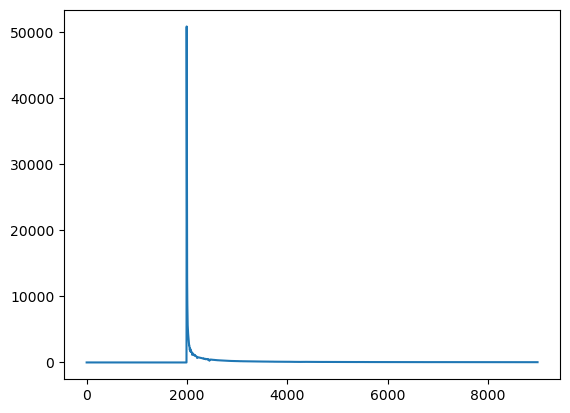

In [15]:
print(len(ON_sums))
print(len(ON_sums[1]))
print(len(ON_sums[1][1]))
plt.plot(ON_sums[-1][0])

In [16]:
from scipy import odr
start = time.time()

bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8991
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]
# print(bg_reg1[0])

def bg_fitsubtract(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
#     seq_bgsub = []
    for seq in range(0, len(ys)): ## number of sequences, usually 13
        fitdata1 = ys[seq][bef_res_reg[0]: bef_res_reg[1]]
        fitdata2 = ys[seq][aft_res_reg[0]: aft_res_reg[1]]
        datasplice = np.append(fitdata1, fitdata2)
#         x = np.linspace(0, len(datasplice),len(datasplice))
        y = datasplice
        data = odr.Data(x, y)
        poly_model3 = odr.polynomial(3)  # using third order polynomial model
        odr_obj = odr.ODR(data, poly_model3)
        output = odr_obj.run()  # running ODR fitting
        poly3 = np.poly1d(output.beta[::-1])
        poly_y3 = poly3(x)
        fullpoly_y3 = poly3(fullx)
        bgsubtracted = ys[seq][bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y3  ## subtracts RealData-BackgroundFit
#         seq_bgsub.append(bgsubtracted)
        ys_bgsub.append(bgsubtracted)
#     ys_bgsub.append(seq_bgsub)
    return ys_bgsub

ON_bgsub = np.zeros((len(ON_sums),len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction
OFF_bgsub = np.zeros((len(ON_sums),len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction

# testfunc = [] ## channels, sequences, range of bg_ subtraction
for i in range(0, len(ON_sums)-1):
#     testfunc.append(bg_fitsubtract(bg_reg1,bg_reg2, ON_sums[i]))
    if chan_enab[i] == 24:
        emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error(run_num + emessage)
        raise Exception(emessage)
#     print(chan_enab[i])
    ON_bgsub[i] = bg_fitsubtract(bg_reg1,bg_reg2, ON_sums[i])
    OFF_bgsub[i] = bg_fitsubtract(bg_reg1,bg_reg2, OFF_sums[i])
    
# for i in range(len(testfunc)):
#     plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, testfunc[i], lw = '1.0', label='3rd Order polynomial background subtracted')

end = time.time()
print('bg_ fitting time: ' + str(end-start))  

bg_ fitting time: 8.448585748672485


In [17]:
print(bg_reg1)
print(bg_reg2)

x = np.arange(bg_reg1[0], bg_reg2[1],1)
print(x)
print(len(x))



[4180, 5450]
[6250, 8991]
[4180 4181 4182 ... 8988 8989 8990]
4811


[111.07450689  -7.50769673  64.35111182  45.21556334 144.71232519
  31.03861078  37.29835869  30.77749253  12.39657475  62.36899084]
[-24.35530079 -49.65121737  19.21512233 192.65261126  38.55937511
 108.29329319 154.01565227 250.00005258 147.05553702  -2.4146863 ]
[ 13.18609806  69.14131367 109.33895009 119.7816137   -1.44792053
 -71.98905191  40.04121226 -47.87784706 -40.66011601 -16.50824105]
[ 53.30396891  42.04472033  36.50948494 -25.51465944  60.3956623
   4.29243841  92.6405872  -69.83981875 -53.54468341  57.7739913 ]
[-10.51962796 -75.12176366 -38.96078754 -25.90981603  83.58339748
 227.9822442  200.66127917 105.08454342 -13.17472087  -2.29184956]
[ 27.38859811  16.44889231 -16.73121736  67.50256056  -7.58622772
   5.29531688   2.16379492  12.47029242  10.45142664   0.63290927]
[-107.05504001  -74.56341549   73.81846392  128.56758656  -25.67392518
  -28.22746323  -12.63947228   13.42310326   30.0845418  -143.72189469]
[ -5.25893359 -42.53694903 -75.57648136  53.00555984  12.934

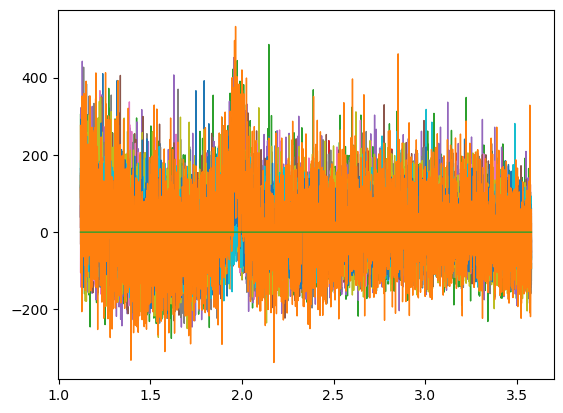

In [18]:

# print((testfunc))
# print((testfunc[0]))
## making sure these are all different
print((ON_bgsub[0][0][50:60]))
print((ON_bgsub[0][1][50:60]))
print((ON_bgsub[0][-1][50:60]))
print((ON_bgsub[0][-2][50:60]))
print((ON_bgsub[3][0][50:60]))
print((ON_bgsub[3][1][50:60]))
print((ON_bgsub[3][-1][50:60]))
print((ON_bgsub[3][-2][50:60]))
print()
print((OFF_bgsub[0][0][50:60]))
print((OFF_bgsub[0][1][50:60]))
print((OFF_bgsub[0][-1][50:60]))
print((OFF_bgsub[0][-2][50:60]))
print((OFF_bgsub[3][0][50:60]))
print((OFF_bgsub[3][1][50:60]))
print((OFF_bgsub[3][-1][50:60]))
print((OFF_bgsub[3][-2][50:60]))

for i in range(len(ON_bgsub)):
    plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, ON_bgsub[i][0], lw = '1.0', label='3rd Order polynomial background subtracted')

In [19]:
%matplotlib qt
print(len(ON_sums))
print(len(ON_sums[0]))
print(len(ON_sums[0][0]))
print(len(ON_sums[0][1]))
print(len(ON_sums[0][2]))
print(len(ON_sums[0][3]))
plt.plot(xs_cut[1], ON_sums[1][0])
plt.axvline(xs_cut[1][bg_reg1[0]])
plt.axvline(xs_cut[1][bg_reg1[1]])
plt.axvline(xs_cut[1][5850], color = 'r')
plt.axvline(xs_cut[1][6250])
plt.axvline(xs_cut[1][bg_reg2[1]])
print(xs_cut[1][bg_reg1[0]])
print(xs_cut[1][bg_reg1[1]])
print(xs_cut[1][6250])
test_polyreg = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]
test_polyregx = xs_cut[1][bg_reg1[0]:bg_reg1[1]]
test_polyreg2 = ON_sums[1][0][6250:bg_reg2[1]]
test_polyregx2 = xs_cut[1][6250:bg_reg2[1]]
plt.plot(test_polyregx, test_polyreg, color = 'y')
plt.plot(test_polyregx2, test_polyreg2, color = 'y')
test_poly_splice = np.append(test_polyreg, test_polyreg2)
test_poly_splicex = np.append(test_polyregx, test_polyregx2)
print(test_poly_splicex)
print(len(test_poly_splice))

13
13
8992
8992
8992
8992
1118208.0
1768448.0
2178048.0
[1118208. 1118720. 1119232. ... 3579904. 3580416. 3580928.]
4011


In [20]:
from scipy import odr

# x = np.linspace(0.0, 5.0)
# y = np.sin(x)
test_polyreg = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]
test_polyregx = xs_cut[1][bg_reg1[0]:bg_reg1[1]]
test_polyreg2 = ON_sums[1][0][6250:bg_reg2[1]]
test_polyregx2 = xs_cut[1][6250:bg_reg2[1]]
plt.plot(test_polyregx, test_polyreg, color = 'y')
plt.plot(test_polyregx2, test_polyreg2, color = 'y')
test_poly_splice = np.append(test_polyreg, test_polyreg2)
test_poly_splicex = np.append(test_polyregx, test_polyregx2)
# x = np.linspace(0, len(fit_reg),len(fit_reg))+xs

In [21]:
%matplotlib qt
from scipy import odr

# x = np.linspace(0.0, 5.0)
# y = np.sin(x)
y = test_poly_splice
# fit_reg = test_poly_splice
# x = np.linspace(0, len(y),len(y))
x1 = np.arange(bg_reg1[0], bg_reg1[1],1)
x2 = np.arange(bg_reg2[0], bg_reg2[1],1)
x = np.append(x1,x2)
# x = np.linspace(0, test_poly_splicex[-1],len(fit_reg))

print(len(x))

# y = test_poly_splice
y = test_poly_splice
data = odr.Data(x, y)
poly_model2 = odr.polynomial(2)  # using third order polynomial model
odr_obj = odr.ODR(data, poly_model2)
output = odr_obj.run()  # running ODR fitting
poly2 = np.poly1d(output.beta[::-1])
poly_y2 = poly2(x)
print(poly_y2[1])
# fullx = np.linspace(0, len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
fullx = np.arange(bg_reg1[0], bg_reg2[1],1)
print(len(fullx))
fullpoly_y2 = poly2(fullx)

poly_model3 = odr.polynomial(3)  # using third order polynomial model
odr_obj = odr.ODR(data, poly_model3)
output = odr_obj.run()  # running ODR fitting
poly3 = np.poly1d(output.beta[::-1])
poly_y3 = poly3(x)
print(poly_y3[1])
# fullx = np.linspace(0, len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
# fullx = np.linspace(0, len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
print(len(fullx))
fullpoly_y3 = poly3(fullx)
print(len(fullpoly_y3))

plt.plot(x, y, label="input data")
# plt.plot(x, (((poly_y2)*-1)+(poly_y2[0]*2)), label="polynomial ODR")
# plt.plot(x, (poly_y2), label="2nd order polynomial ODR")
# plt.plot(x[0:1270], (poly_y2[0:1270]), label="beginning?")
# plt.plot(x, (((poly_y3)*-1)+(poly_y3[0]*2)), label="polynomial ODR")
plt.plot(x, (poly_y3), label="3rd order polynomial ODR")
plt.plot(fullx, (fullpoly_y3), label="3rd order polynomial ODR")
# plt.plot(x[0:1270], (poly_y3[0:1270]), label="beginning?")
# plt.axvline(x[2180], color ='r')
plt.title('fits to background data') 
plt.xlabel("bins", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
print(len(poly_y2))


4011
486.63121033326354
4811
461.63707309756603
4811
4811
4011


In [22]:
plt.plot(xs_cut[1], ON_sums[1][0])

plt.plot(xs_cut[1][bg_reg1[1]:6250], ON_sums[1][0][bg_reg1[1]:6250], label="input data")
# plt.plot(test_poly_splicex, (((poly_y)*-1)+(poly_y[0]*2)), label="polynomial ODR")
plt.plot(test_poly_splicex, (poly_y2), label="2nd order polynomial ODR")
plt.plot(test_poly_splicex, (poly_y3), label="3rd order polynomial ODR")

plt.legend()
plt.show()

In [23]:
plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')
# plt.plot(test_poly_splicex, y, label="Background input data")
plt.plot(test_polyregx*1e-6, test_polyreg, label='Background input data', color ='#ff7f0eff', lw = '1.0')
plt.plot(test_polyregx2*1e-6, test_polyreg2, color = '#ff7f0eff', lw = '1.0')
plt.plot(xs_cut[1][bg_reg1[1]:6250]*1e-6, ON_sums[1][0][bg_reg1[1]:6250], label="Resonance region", color = 'r', lw = '1.0')
# plt.plot(test_poly_splicex, (((poly_y)*-1)+(poly_y[0]*2)), label="polynomial ODR")
# plt.plot(test_poly_splicex, (poly_y), label="polynomial ODR")
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (fullpoly_y2), label="2nd order background polynomial fit", color = 'magenta', lw = '3.0', ls = '-')
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (fullpoly_y3), label="3rd order background polynomial fit", color = 'g', lw = '3.0', ls = ':')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (poly_y2), label="2nd order background polynomial fit", color = 'magenta', lw = '3.0', ls = '-')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (poly_y3), label="3rd order background polynomial fit", color = 'g', lw = '3.0', ls = ':')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()

In [111]:
plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')
reg_full = ON_sums[1][0][bg_reg1[0]:8992]
xs_bg_reg = xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6  ## new 11.21.24
# left = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]-poly_y[0:1270]
# right = ON_sums[1][0][6250:bg_reg2[1]]-poly_y[1270:]
bgsubtracted2 = ON_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2
bgsubtracted3 = ON_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y3
bgsubtracted2OFF = OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2

# plt.plot(test_polyregx, left, color = 'y')
# plt.plot(test_polyregx2, right, color = 'r')
plt.plot(xs_cut[1][bg_reg1[0]:8992]*1e-6, reg_full, color = '#ff7f0eff', lw = '1.0', label = 'full bg_ subtraction region')

# res_only = np.append(left,ON_sums[1][0][bg_reg1[1]:6250])
# res_only = np.append(res_only,right)
plt.plot(xs_bg_reg, bgsubtracted2, color = 'r', lw = '1.0', label='2nd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, bgsubtracted3, color = 'g', lw = '1.0', label='3rd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]-ON_sums[1][0][bg_reg1[0]:bg_reg2[1]], color = 'g', lw = '1.0', label='simple subtraction')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_bgsub[1][0]-ON_bgsub[1][0], color = 'm', lw = '1.0', label='fit subtraction?')

plt.axhline(0, ls='--')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()


In [29]:
print(ON_bgsub[1][0] - ON_sums[1][0][bg_reg1[0]:bg_reg2[1]])
print(OFF_bgsub[1][0] - OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]])
print(OFF_bgsub[1][0] - ON_bgsub[1][0])
print(OFF_sums[1][1][bg_reg1[0]:bg_reg2[1]]-ON_sums[1][1][bg_reg1[0]:bg_reg2[1]])
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6,ON_bgsub[1][0] - ON_sums[1][0][bg_reg1[0]:bg_reg2[1]])

[-461.66872657 -461.6370731  -461.6053824  ... -286.17578776 -286.21913013
 -286.26254094]
[-467.08254142 -467.04754848 -467.01251754 ... -286.07465439 -286.123068
 -286.17155431]
[  79.63744516 -139.36974854   24.19290166 ...   51.56799882  -81.48918699
  -57.82290277]
[ -16.43320231 -132.70170788  -47.03146727 ...    9.7021881  -104.31219871
   -3.0115005 ]


now OFF ones

In [30]:
test_polyreg = OFF_sums[1][0][bg_reg1[0]:bg_reg1[1]]
test_polyregx = xs_cut[1][bg_reg1[0]:bg_reg1[1]]
test_polyreg2 = OFF_sums[1][0][6250:bg_reg2[1]]
test_polyregx2 = xs_cut[1][6250:bg_reg2[1]]
# plt.plot(test_polyregx, test_polyreg, color = 'y')
# plt.plot(test_polyregx2, test_polyreg2, color = 'y')
test_poly_splice = np.append(test_polyreg, test_polyreg2)
test_poly_splicex = np.append(test_polyregx, test_polyregx2)
y = test_poly_splice
x = np.linspace(0, len(y),len(y))
# x = np.linspace(0, test_poly_splicex[-1],len(fit_reg))

print(len(x))

data = odr.Data(x, y)
poly_model3 = odr.polynomial(3)  # using third order polynomial model
odr_obj = odr.ODR(data, poly_model3)
output = odr_obj.run()  # running ODR fitting
poly3 = np.poly1d(output.beta[::-1])
poly_y3 = poly3(x)
print(poly_y3[1])
fullx = np.linspace(0, len(OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
print(len(fullx))
fullpoly_y3OFF = poly3(fullx)

plt.plot(x, y, label="input data")
# plt.plot(x[0:1270], (poly_y2[0:1270]), label="beginning?")
# plt.plot(x, (((poly_y3)*-1)+(poly_y3[0]*2)), label="polynomial ODR")
plt.plot(x, (poly_y3), label="3rd order polynomial ODR")
# plt.plot(x[0:1270], (poly_y3[0:1270]), label="beginning?")
# plt.axvline(x[2180], color ='r')
plt.title('fits to background data OFF pulses') 
plt.xlabel("bins", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
print(len(poly_y2))

4011
520.0024114411128
4811
4011


In [31]:
plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')
reg_full = ON_sums[1][0][bg_reg1[0]:8992]
# left = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]-poly_y[0:1270]
# right = ON_sums[1][0][6250:bg_reg2[1]]-poly_y[1270:]
bgsubtracted = ON_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y3
# plt.plot(test_polyregx, left, color = 'y')
# plt.plot(test_polyregx2, right, color = 'r')
# plt.plot(xs_cut[1][bg_reg1[0]:8992]*1e-6, reg_full, color = '#ff7f0eff', lw = '1.0', label = 'full fitting region')

# res_only = np.append(left,ON_sums[1][0][bg_reg1[1]:6250])
# res_only = np.append(res_only,right)
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, bgsubtracted, color = 'g', lw = '1.0', label='3rd Order polynomial background subtracted')
plt.axhline(0, ls='--')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()

Now voigt

In [32]:
# plt.plot(xs_cut[0], ON_sums[-1][0])
# plt.plot(xs_cut[0], ON_sums[-1][1])
# plt.plot(xs_cut[0], ON_sums[-1][2])
# plt.plot(xs_cut[0], ON_sums[-1][3])
# plt.plot(xs_cut[0], ON_sums[-1][4])

In [33]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
voigt_profile(2, 1., 1.)
fig, ax = plt.subplots(figsize=(8, 8))
x = np.linspace(-10, 10, 500)
parameters_list = [(1.5, 0., "solid"), (1.3, 0.5, "dashed"),
                   (0., 1.8, "dotted"), (1., 1., "dashdot")]
for params in parameters_list:
    sigma, gamma, linestyle = params
    voigt = voigt_profile(x, sigma, gamma)
    ax.plot(x, voigt, label=rf"$\sigma={sigma},\, \gamma={gamma}$",
            ls=linestyle)
plt.legend()
plt.show()

In [34]:
print(xs_cut[0]/256)

[-3992. -3990. -3988. ... 13986. 13988. 13990.]


In [145]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]

## checks that the resonance region and bg region do not overlap 11.21.24
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error(run_num + emessage)
    raise Exception(emessage)

## manual fitting
# sigma = 60
# gamma = 30
# beg = 5800
# end = 5900
sigma = 0.05
gamma = 0.09
beg = 5800
end = 5900

shift = 1.98
mult = 100

# xdata = np.arange(-(res_reg[1]-res_reg[0])/2,(res_reg[1]-res_reg[0])/2,1)  ## centered around 0 for initial fitting
xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6

ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

voigt = voigt_profile(xdata-shift, sigma, gamma)*mult
# print(voigt)
# def voigt2(x, sig, gam, xshift, amp):
#     fit = voigt_profile(x-xshift, sig, gam)*amp
#     return fit

plt.plot(xdata, voigt)
plt.plot(xdata,ydata)

In [149]:
print(bg_reg1[1]-bg_reg1[0])
print(bg_reg2[0]-bg_reg1[0])
print(res_reg)
print(res_reg[1]-res_reg[0])


1270
2070
[5450, 6250]
800


In [102]:
print(xdata)

[1.768448 1.76896  1.769472 1.769984 1.770496 1.771008 1.77152  1.772032
 1.772544 1.773056 1.773568 1.77408  1.774592 1.775104 1.775616 1.776128
 1.77664  1.777152 1.777664 1.778176 1.778688 1.7792   1.779712 1.780224
 1.780736 1.781248 1.78176  1.782272 1.782784 1.783296 1.783808 1.78432
 1.784832 1.785344 1.785856 1.786368 1.78688  1.787392 1.787904 1.788416
 1.788928 1.78944  1.789952 1.790464 1.790976 1.791488 1.792    1.792512
 1.793024 1.793536 1.794048 1.79456  1.795072 1.795584 1.796096 1.796608
 1.79712  1.797632 1.798144 1.798656 1.799168 1.79968  1.800192 1.800704
 1.801216 1.801728 1.80224  1.802752 1.803264 1.803776 1.804288 1.8048
 1.805312 1.805824 1.806336 1.806848 1.80736  1.807872 1.808384 1.808896
 1.809408 1.80992  1.810432 1.810944 1.811456 1.811968 1.81248  1.812992
 1.813504 1.814016 1.814528 1.81504  1.815552 1.816064 1.816576 1.817088
 1.8176   1.818112 1.818624 1.819136 1.819648 1.82016  1.820672 1.821184
 1.821696 1.822208 1.82272  1.823232 1.823744 1.824256

In [103]:
# xdata = np.arange(-(res_reg[1]-res_reg[0])/2,(res_reg[1]-res_reg[0])/2,1)
# print(xdata)
ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
print(ydata)

[ 1.58266717e+01 -2.44821727e+01 -1.25020263e+01  1.58652762e+02
  2.99367057e+01 -5.57728488e+01 -6.32707832e+01 -8.49923196e+01
  3.63822161e+01 -8.51527307e+00  3.17877631e+01 -3.31609494e+01
 -1.21791006e+01  4.46455756e+01  3.66255455e+01 -1.90158945e+01
 -1.12230103e+01 -2.27119999e+01  1.56570648e+01 -2.52010018e+01
 -5.58057822e+01 -5.79983212e+01  5.27957122e+01  1.28943931e+02
  7.98736909e+01  1.03032810e+02 -3.28085514e+01 -3.19193176e+01
  1.74255246e+02  6.32045609e+01 -6.43901389e+01 -5.19082134e+01
  4.61201646e+01 -5.44401149e+01 -9.99767610e+01 -1.91709117e+02
 -9.50348066e+01 -3.80928583e+01 -6.20242598e+01  1.83819839e+01
  5.56670694e+00 -1.37484763e+02 -7.27142086e+01 -4.79607512e+01
 -8.75192765e+01 -1.18354140e+02 -3.64790956e+01 -5.02017941e+01
 -9.46049083e+00  6.61032950e+00 -8.94245738e+01  4.27592258e+01
 -2.41288902e+01 -1.40036340e+02 -1.31439883e+02  1.69385970e+01
  5.89522426e+01 -9.57479101e+00 -2.77795611e+01  4.72933461e+01
  4.98219209e+00 -6.35270

In [104]:
def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs


In [131]:
def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

popt, pcov = curve_fit(voigt2, xdata, ydata)
print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)

rebinf = 4
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)

[ 0.0873466  -0.0919887   1.96389844  7.44750923]
[[ 8.89759935e-05 -2.26564729e-04 -4.01927223e-07 -9.05641503e-03]
 [-2.26564729e-04  6.16495051e-04  1.04978569e-06  2.69557047e-02]
 [-4.01927223e-07  1.04978569e-06  8.92940524e-06  4.13137325e-05]
 [-9.05641503e-03  2.69557047e-02  4.13137325e-05  1.41657171e+00]]


In [138]:
## plotting voigt fit ##

# plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

# plt.plot(xdata, voigt, label = 'manual fit')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$")

rebinf = 2
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)

# plt.plot(xdata,ydata, label = r'rawdata')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata, rebin {rebinf}')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

In [122]:
## more plotting ##

plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

# plt.plot(xdata, voigt, label = 'manual fit')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$")

rebinf = 4
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)

# plt.plot(xdata,ydata, label = r'rawdata')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata for voigt fit, rebin {rebinf}')

plt.axhline(y=0, ls = '--', lw = '0.5')
plt.title('Voigt fit to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

In [130]:
## more more plotting ##

plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

rebinf = 4
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)
ys_region_rebin, xs_region_rebin = rebin(bgsubtracted2[3:], xs_bg_reg[3:], rebinf)


# plt.plot(xs_bg_reg, bgsubtracted2, color = 'orange', lw = '1.0', label='2nd Order polynomial background subtracted')
plt.plot(xs_region_rebin, ys_region_rebin, color = 'orange', lw = '1.0', label='2nd Order polynomial background subtracted')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata for voigt fit, rebin {rebinf}', color = 'g')

# plt.plot(xdata, voigt, label = 'manual fit')

# plt.plot(xdata,ydata, label = r'rawdata')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$", color = 'r')

plt.axhline(y=0, ls = '--', lw = '0.5')
plt.title('Voigt fit to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

In [137]:
# print(fitted_curve)
print(max(fitted_curve))
print(min(fitted_curve))

print(sum(fitted_curve))

101.14246629700477
-16.478186809814233
20014.35237426118


In [67]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
Resregion_beg = 5450
Resregion_end = 6250
Resreg = [Resregion_beg,Resregion_end]
# voigt_profile(2, 1., 1.)
# fig, ax = plt.subplots(figsize=(8, 8))
# x = np.linspace(-10, 10, 500)
# parameters_list = [(1.5, 0., "solid"), (1.3, 0.5, "dashed"),
#                    (0., 1.8, "dotted"), (1., 1., "dashdot")]
# for params in parameters_list:
#     sigma, gamma, linestyle = params
#     voigt = voigt_profile(x, sigma, gamma)
#     ax.plot(x, voigt, label=rf"$\sigma={sigma},\, \gamma={gamma}$",
#             ls=linestyle)
sigma = 60
gamma = 30
beg = 5800
end = 5900
print(bg_reg1[1]-bg_reg1[0])
print(bg_reg2[0]-bg_reg1[0])
print(len(ON_bgsub[1][0]))
# xdata = xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6
# xdata = np.arange(Resreg[0],Resreg[1],1)
xdata = np.arange(-(Resreg[1]-Resreg[0])/2,(Resreg[1]-Resreg[0])/2,1)
# print(xdata[380:420])
print(len(xdata))
# ydata = ON_sums[1][0][bg_reg1[1]:6250]
# xdata = xs_cut[1][beg:end]
# ydata = ON_sums[1][0][beg:end]
ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
print(len(ydata))

voigt = voigt_profile(xdata, sigma, gamma)*30000
# print(voigt)
plt.plot(xdata, voigt)
plt.plot(xdata,ydata)
plt.show()
popt, pcov = curve_fit(voigt_profile, xdata, ydata)
plt.plot(xs_cut[1][bg_reg1[1]:6250], ON_sums[1][0][bg_reg1[1]:6250], label="input data")
plt.plot(xdata, voigt)
popt, pcov = curve_fit(voigt, xdata, ydata)

# popt
# array([2.56274217, 1.37268521, 0.47427475])

# plt.plot(xdata, func(xdata, *popt), 'r-',

#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

1270
2070
4811
800
800


ValueError: callable <ufunc 'voigt_profile'> is not supported by signature

all_ONOFF = np.zeros((len(ON_sums),2, len(ON_sums[0][0])), dtype=np.float64) ## all summed ON[0] and OFF[1] pulses for each channel, not each sequence

def all_onoff(ON_arr, OFF_arr):
    tempallON = np.zeros((len(ON_arr[0])), dtype=np.float64)
    tempallOFF = np.zeros((len(ON_arr[0])), dtype=np.float64)
    for seq in range(0, len(ON_arr)): ## number of sequences
        tempallON = np.add(ON_arr[seq],tempallON)
        tempallOFF = np.add(OFF_arr[seq],tempallOFF)
    return tempallON, tempallOFF

for i in range(len(ON_sums)):
    all_ONOFF[i][0], all_ONOFF[i][1] = all_onoff(ON_sums[i], OFF_sums[i]) ## channel, ON[0] or OFF[1], summed wave
    # print('ch done')

In [16]:
print(len(ON_sums))
print(len(ON_sums[0]))
print(len(ON_sums[0][0]))
print(len(all_ONOFF))
print(len(all_ONOFF[0]))
print(len(all_ONOFF[0][0]))

13
13
8992
13
2
8992


In [17]:
start = time.time()
# testch = 0

with h5py.File(ONOFFSavename+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0], compression="gzip")
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
    hdf5_file.create_dataset('xs ', data=xs_cut[0]) ## all xs are the same, even though they are per channel...
    hdf5_file.attrs['sequences'] = len(sequence[0])
    hdf5_file.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
    for i in range(0,len(ys_cut)):
#         with h5py.File('test_allONOFFs'+'.h5', 'a') as hdf5_file:
#         hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i], compression="gzip")
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i])
#     a = hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
#     a.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
#     a.attrs['sequences'] = len(sequence[0])
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'F:\LANL/processed_data/debug_sample/runs12034-12363/ONOFF_D/12036_ONOFF_D.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [ ]:
## testing reaad
with h5py.File(ONOFFSavename+'.h5', 'r') as f:
    print(f.attrs.keys())
    print(f.attrs.get('sequences'))
    print(f.attrs.get('rownames'))
    f.close()
    
# f = h5py.File('test_allONOFFs'+'.h5', 'r')
# # print(f['ch 00'].attrs.get('sequences'))
# f.close()

In [ ]:
asym_ch = np.zeros((len(ON_sums), len(ON_sums[0][0])), dtype=np.float64) ## 1 Asym for each channel, not for each sequence (can change?)
# asym_pm = np.zeros((len(ONOFF_plus_sums),2, len(ONOFF_plus_sums[0][0][0])), dtype=np.float64) ## 1 Asym for each channel, not for each sequence (can change?)

def asym2(ON_arr, OFF_arr):
    tempasym = np.zeros((len(ON_arr[0])), dtype=np.float64)
    for seq in range(0, len(ON_arr)): ## number of sequences
        seqasym = ((ON_arr[seq]-OFF_arr[seq]) / (ON_arr[seq]+OFF_arr[seq]))
        tempasym = np.add(seqasym,tempasym)
    normedasym = tempasym/len(ON_arr)
    return normedasym

for i in range(len(ON_sums)):
    asym_ch[i] = asym2(ON_sums[i], OFF_sums[i])
#     asym_pm[i][0] = asym2(ONOFF_plus_sums[i][0], ONOFF_plus_sums[i][1])
#     asym_pm[i][1] = asym2(ONOFF_minus_sums[i][0], ONOFF_minus_sums[i][1])

In [ ]:
print((asym_ch).shape)
print(asym_ch[0].shape)

In [ ]:
%matplotlib qt
ch = 2
plt.title(f'Summed Pulses for channel {ch}')
plt.plot(xs_cut[ch]*1e-6, all_ONOFF[ch][0], label='ON states')
# plt.plot(xs_cut[ch], all_ONOFF[ch][1], label='OFF states')
# plt.plot(xs_cut[ch], asym_ch_raw[ch], label='asymmetry')  ## there's no point in looking at asym for one channel. Need more data
# plt.plot(fullx, asym_ch_bg[ch], label='asymmetry')  # division by 0 is a problem...
plt.plot((fullx-2000+8)*(decFactor[1]*16*1e-6), asym_ch_bg[ch], label='asymmetry')  # division by 0 is a problem...

plt.axvline(x = 1.97, label='p-wave peak?')

plt.legend()
plt.show()

In [21]:
start = time.time()

with h5py.File(AsymSavename+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0], compression="gzip")
    hdf5_file.create_dataset('xs ', data=xs_cut[0])
    hdf5_file.attrs['sequences'] = len(sequence[0])
    for i in range(0,len(ys_cut)):
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=asym_ch[i])
        
# f = gzip.GzipFile("testcompressednparr.npy.gz", "w")
# np.save(file=f, arr=ys_cut)
# f.close()
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 0.061153411865234375


In [ ]:
## testing reaad
with h5py.File(AsymSavename+'.h5', 'r') as f:
    print(f.attrs.keys())
    print(f.attrs.get('sequences'))
    print(f.attrs.get('rownames'))
    f.close()

In [ ]:
# start = time.time()

# np.save(os.getcwd() + '/testnpysave', asym_ch)
# np.save(os.getcwd() + '/processed_data/'+ 'xs_cut', xs_cut)
# # np.save(os.getcwd() + pmSavename, asym_pm)
# # np.save(os.getcwd() + AsymSavename, Asym)
# end = time.time()
# print('saving as npy ' + str(end-start))  

In [ ]:
fullend = time.time()
print('full processing time: ' + str(fullend-fullstart))  
print('finished ' + str(datetime.now())) 
print('\n')

## end of data processing ##

## saving to hdf5 ##

In [28]:
import h5py
import gzip

In [25]:
b = np.char.zfill(str(chan_enab[11]), 2)
print(b)
print(type(b))
ch_list = str(chan_enab)

11
<class 'numpy.ndarray'>


In [30]:
## straight numpy save
# Save the NumPy array to an HDF5 file
with h5py.File('testtesttest_ysh5'+'.h5', 'w') as hdf5_file:
    hdf5_file.create_dataset('dataset', data=ys_cut)

# # Read the NumPy array from the HDF5 file
# with h5py.File(hdf5_file_path, 'r') as hdf5_file:
#     loaded_array = hdf5_file['dataset'][:]

In [30]:
# try compression
start = time.time()

testch = 0

with h5py.File('test_addingmultipleys'+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[testch]), data=ys_cut[testch])
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=ys_cut[0], compression="gzip")
    hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=ys_cut[testch])
    
# i = 2
# with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[i]), data=ys_cut[i])

for i in range(1,len(ys_cut)):
    with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
#         hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=ys_cut[i], compression="gzip")
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=ys_cut[i])
        
# f = gzip.GzipFile("testcompressednparr.npy.gz", "w")
# np.save(file=f, arr=ys_cut)
# f.close()
        
end = time.time()
print('saving hdf5: ' + str(end-start))

saving hdf5: 8.730424404144287


In [29]:
# Save the NumPy array to an HDF5 file
start = time.time()

testch = 0

with h5py.File('test_addingmultipleys'+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[testch]), data=ys_cut[testch])
    hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=ys_cut[testch])

    
# i = 2
# with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[i]), data=ys_cut[i])

for i in range(1,len(ys_cut)):
    with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=ys_cut[i])
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 8.799411296844482


In [33]:
## try compressed np array
start = time.time()

f = gzip.GzipFile("testcompressednparr.npy.gz", "w")
np.save(file=f, arr=ys_cut)
f.close()

end = time.time()
print('saving hdf5: ' + str(end-start))   

saving hdf5: 236.83496618270874


In [28]:
testdf = pd.DataFrame(ys_cut[0])
# print(testdf)
testdf.to_hdf('testing1chdf.h5', key='df', mode='w')

In [12]:
start = time.time()

np.save('testing_cutys_npoutput', ys_cut)

end = time.time()
print('aligning and cutting time: ' + str(end-start))   

aligning and cutting time: 10.02809476852417


## older stuff ##

In [18]:
# OLD: changed to just saving ON and OFF pulses. Keeping if needed in later use. 09.30.2024

#  add up pulses for their respective state, in each 8 step sequence ##
#  turning into a by-channel function 06.13.24 ##

start = time.time()
sequence = np.asarray(sequence, dtype = object)

# added_pulses = np.zeros((len(ys_cut), len(sequence[0]), 8, len(ys_cut[0][0])), dtype=np.float64) ## 13 sequences, 8 stages each works?
# i channels, 13 sequences each, 8 states each sequence, 8992 num points ##

ON_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF
ONOFF_minus_sums = np.zeros((len(ys_cut), len(sequence[0]),2, len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
ONOFF_plus_sums = np.zeros((len(ys_cut), len(sequence[0]),2, len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF

# ON_OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), 2, len(ys_cut[0][0])), dtype=np.float64) ## 13 sequences, 2 for ON or OFF for each sequence
# ON_sums = np.zeros((len(ys_basesub), len(sequence[0]), len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
# OFF_sums = np.zeros((len(ys_basesub), len(sequence[0]), len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF
# ON_minus_sums = np.zeros((len(ys_basesub), len(sequence[0]),2, len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
# ON_plus_sums = np.zeros((len(ys_basesub), len(sequence[0]),2, len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF
# ON_minus/plus_sums have their 2 for associated OFF states in the second array

# @njit
def add_pulse(ys, SFarr):
#     tempadded_p = np.zeros((len(SFarr[0]), 8, len(ys[0])), dtype=np.float64)
    temp_ON = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    temp_OFF = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    temp_ONOFF_min = np.zeros((len(SFarr[0]),2, len(ys[0])), dtype=np.float64)
    temp_ONOFF_plu = np.zeros((len(SFarr[0]),2, len(ys[0])), dtype=np.float64)
    for seq in range(0, len(SFarr[0])): ## for every sequence
    #         print('seq:' +str(SFarr[0][seq]))
#         print('seq:' +str(seq))
        for state in range(0, len(SFarr[1][0])): ## for every state in the sequence
    #         print("states loop " + str(range(0, len(SFarr[1][0]))[0]) + ' - ' +  str(range(0, len(SFarr[1][0]))[-1]))
            s = SFarr[1][seq][state] ## try this to condense code. Basically, the state currently at
            if s==0 or s==3 or s==5 or s==6: ## these are ON states
#                 print('ON "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                    temp_ON[seq] = np.add(temp_ON[seq],ys[p]) ## start with zeros, add to each iteratively
#                     print(p)
                #         below is for splitting up into ON(-) and ON(+) and their associated OFF states (1 state forward for -, 1 state backward for +)
                if s==0 or s==6: ## these or ON(-) states
                    OFF_i = np.where(np.asarray(SFarr[1][0])==s+1)[0][0] ## find where in sequence state = s(ON-)+1    
    #                 print('ON(-) "s" ' +str(s) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
                    for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_min[seq][0] = np.add(temp_ONOFF_min[seq][0],ys[p]) ## start with zeros, add to each iteratively
    #                 print('OFF state ' + str(SFarr[1][seq][OFF_i]))
                    for p in range((SFarr[2][seq][OFF_i][0]),(SFarr[2][seq][OFF_i][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_min[seq][1] = np.add(temp_ONOFF_min[seq][1],ys[p]) ## start with zeros, add to each iteratively
                if s==3 or s==5: ## these or ON(+) states
                    OFF_i = np.where(np.asarray(SFarr[1][0])==s-1)[0][0] ## find where in sequence state = s(ON+)-1    
    #                 print('ON(+) "s" ' +str(s) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
                    for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_plu[seq][0] = np.add(temp_ONOFF_plu[seq][0],ys[p]) ## start with zeros, add to each iteratively
    #                 print('OFF state ' + str(SFarr[1][seq][OFF_i]))
                    for p in range((SFarr[2][seq][OFF_i][0]),(SFarr[2][seq][OFF_i][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_plu[seq][1] = np.add(temp_ONOFF_plu[seq][1],ys[p]) ## start with zeros, add to each iteratively
            if s==1 or s==2 or s==4 or s==7: ## these are OFF states
#                 print('OFF "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                    temp_OFF[seq] = np.add(temp_OFF[seq],ys[p]) ## start with zeros, add to each iteratively
#                     print(p)
    return temp_ON, temp_OFF, temp_ONOFF_min, temp_ONOFF_plu

for i in range(len(ys_cut)):
#     print('#################### channel: ' + str(i) + ' ##########################')
    ON_sums[i], OFF_sums[i], ONOFF_minus_sums[i], ONOFF_plus_sums[i] = add_pulse(ys_cut[i], sequence)
    
# for i in range(len(ys_basesub)-12):
#     print('#################### channel: ' + str(i) + ' ##########################')
#     ON_sums[i], OFF_sums[i], ON_minus_sums[i], ON_plus_sums[i] = add_pulse(ys_basesub[i], sequence)

end = time.time()
print('summing pulses into their states time: ' + str(end-start))  

summing pulses into their states time: 0.7072417736053467
